# [Hackerearth Predict the Emotion Challenge from audio files](https://www.hackerearth.com/challenges/competitive/ia-for-ai/)

![Problem Statement](https://i.ibb.co/Yf1948g/hackimg.png)


## My Bronze Medal 3rd Place Solution Write Up:

* **Leaderboard Rank** : https://www.hackerearth.com/challenges/competitive/ia-for-ai/leaderboard/

![imgage_leaderboard](https://i.ibb.co/wwWnzvM/hackerearth-emotio-detection-leaderboard.png)

* Firstly, I was occupied in my exams didn't have time. I accidently opened hackerearth found the comeptition been going on for about a month.

* I just joined the competition 3 days before the completion.

* So, Being time constrained, I don't time to experiment a lot. First I thought of using torchaudio models. But ran a first draft through it.

* Then I thought, though torchaudio model could give better given time. To do a fast experiment I have to use CNNs, with spectograms.

* I did audio exploration files conatined both mp3 wav. Since I didn't have attened AMA in beginnig didn't find proper meta regarding audio files. I assumed they were sample at traditional 44100 Hz.

* I used a 5 fold Stratified KFold.

* After exploring the audio lengths. They varied from 0.5s to > 22.0s. I took a distibution of lengths of audio files, took a max lenths of 5 secs for audion spectrograms of size (128,455). If files were less than 5.0s, They were extrpolated of to 5 sec using zeros.

* Converted the train and Test files into MelSpecgrams using librosa audio library. Saved on the drive.

* Choose fastai instead of traditional core pytorch. And changed fastai's codes were needed. 

* Experimented with 6 models architectures. 
    * resnet50
    * efficientnet b0-b4.

* There individual best scores varied from 57 to 59
* I tried making ensemble using different weights to 5 models, they didn't gave better results.
* So for final submission and best score of **61.0835**. I simply took a mode of my best submissions of above 6 models.




In [ ]:
!pip install -q gdown
!pip install -q torchaudio

     |████████████████████████████████| 1.9 MB 5.2 MB/s 


In [ ]:
import albumentations
import pandas as pd
import plotly.express as px
import seaborn as sns
import torch,os
from tqdm.notebook import tqdm
import torch.nn as nn
from torch.nn import functional as F
import torchaudio
import gdown
import librosa
import numpy as np
import IPython
import matplotlib.pyplot as plt
import audioread
import cv2
import librosa
import cv2,os
from sklearn.model_selection import train_test_split
import torch.nn as nn
import random,os,gc,sys

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Downloading data

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=131jmLqPqORC6hdRLaFGb_HEYCtBdPURS' 
output = 'dbb3bd26ead211eb.zip' 
gdown.download(url, output, quiet=False)

In [ ]:
!unzip -qq /content/dbb3bd26ead211eb.zip

In [ ]:
df = pd.read_csv('/content/dataset/train.csv')

In [ ]:
df['file_path'] = df['filename'].apply(lambda x:f'/content/dataset/TrainAudioFiles/{x}')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5816 entries, 0 to 5815
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   5816 non-null   object
 1   emotion    5816 non-null   object
 2   file_path  5816 non-null   object
dtypes: object(3)
memory usage: 136.4+ KB


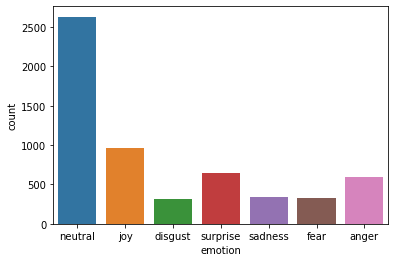

In [ ]:
sns.countplot(x=df.emotion);

In [ ]:
emotion_map = {'neutral':0, 'joy':1, 'disgust':2, 'surprise':3, 'sadness':4, 'fear':5,'anger':6}

In [ ]:
inv_emo = {v: k for k, v in emotion_map.items()};

In [ ]:
df['target'] = df['emotion'].map(emotion_map)

In [ ]:
df.sample(n=10)

,filename,emotion,file_path,target
4408,18257.mp3,neutral,/content/dataset/TrainAudioFiles/18257.mp3,0
1809,24696.mp3,neutral,/content/dataset/TrainAudioFiles/24696.mp3,0
726,43507.wav,fear,/content/dataset/TrainAudioFiles/43507.wav,5
5489,28559.mp3,neutral,/content/dataset/TrainAudioFiles/28559.mp3,0
457,12562.mp3,neutral,/content/dataset/TrainAudioFiles/12562.mp3,0
2024,2469.mp3,neutral,/content/dataset/TrainAudioFiles/2469.mp3,0
4516,1752.mp3,neutral,/content/dataset/TrainAudioFiles/1752.mp3,0
2910,12359.mp3,surprise,/content/dataset/TrainAudioFiles/12359.mp3,3
4647,24165.mp3,surprise,/content/dataset/TrainAudioFiles/24165.mp3,3
1749,22569.mp3,surprise,/content/dataset/TrainAudioFiles/22569.mp3,3


In [ ]:
loc = df.loc[2910,'file_path']
lbl = df.loc[2910,'emotion'];lbl

'surprise'

In [ ]:
wave,sr = librosa.load(loc,sr=44100)
print(f'Duration of audio file {len(wave)/sr} secs')

Duration of audio file 3.15 secs


In [ ]:
IPython.display.Audio(loc)

In [ ]:
MFCCs = librosa.feature.mfcc(wave,sr=sr)
spec_centroid = librosa.feature.spectral_centroid(y=wave, sr=sr)
chroma_stft = librosa.feature.chroma_stft(y=wave, sr=sr)
spec_bw = librosa.feature.spectral_bandwidth(y=wave, sr=sr)
mel_spec = librosa.feature.melspectrogram(y=wave, sr=44100)
mel_specimg = librosa.power_to_db(mel_spec)

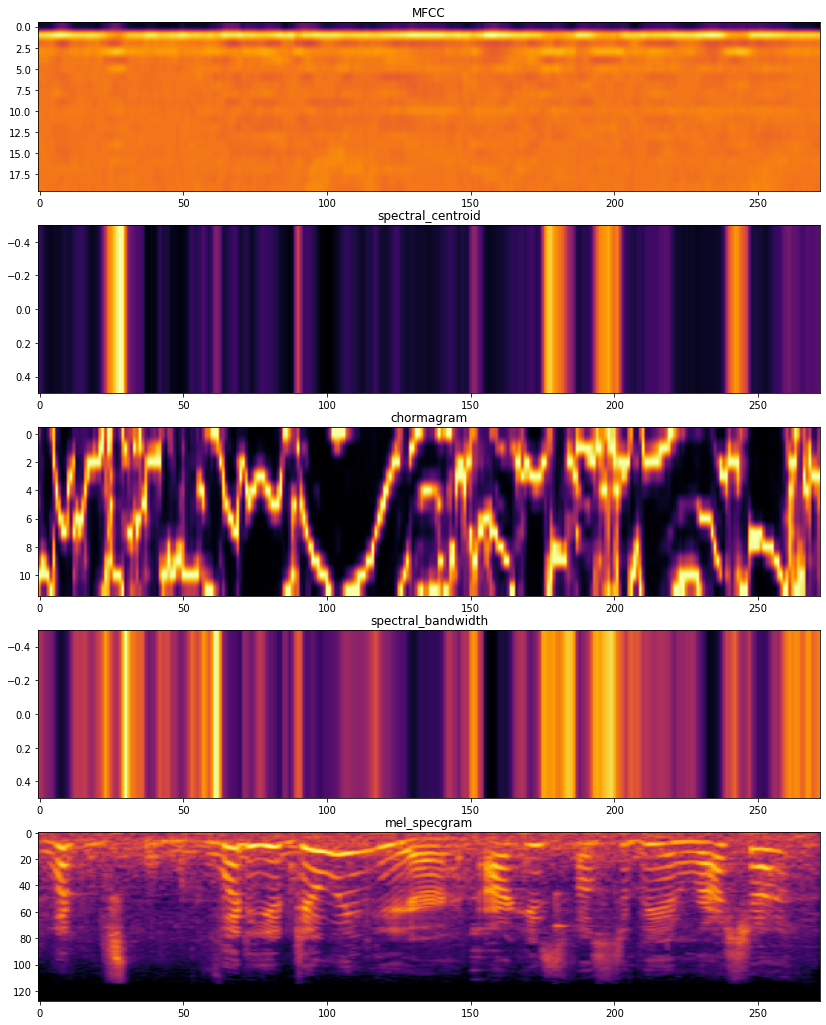

In [ ]:
plt.figure(1,figsize=(14,18))
plt.subplot(511)
plt.imshow(MFCCs,aspect='auto',cmap='inferno');plt.title('MFCC');
plt.subplot(512)
plt.imshow(spec_centroid,aspect='auto',cmap='inferno');plt.title('spectral_centroid');
plt.subplot(513)
plt.imshow(chroma_stft,aspect='auto',cmap='inferno');plt.title('chormagram');
plt.subplot(514)
plt.imshow(spec_bw,aspect='auto',cmap='inferno');plt.title('spectral_bandwidth');
plt.subplot(515)
plt.imshow(mel_specimg,aspect='auto',cmap='inferno');plt.title('mel_specgram');

In [ ]:
#from https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
#     X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

In [ ]:
def build_spectrogram(path,srate=44100):
    y, sr = librosa.load(path,sr=srate)
    M = librosa.feature.melspectrogram(y=y, sr=srate)
    M = librosa.power_to_db(M)
    x1,y1 = M.shape
    temp_img = np.zeros((128,455))
    if y1<455:
        temp_img[0:x1,0:y1] = M[:]
    else:
        temp_img[:] = M[:128,0:455]
    img = mono_to_color(temp_img)
    return img

In [ ]:
df.sample(n=5)

,filename,emotion,file_path,target
3753,8302.mp3,neutral,/content/dataset/TrainAudioFiles/8302.mp3,0
3229,15090.mp3,neutral,/content/dataset/TrainAudioFiles/15090.mp3,0
4990,5057.mp3,joy,/content/dataset/TrainAudioFiles/5057.mp3,1
2291,46181.wav,fear,/content/dataset/TrainAudioFiles/46181.wav,5
4861,47321.wav,disgust,/content/dataset/TrainAudioFiles/47321.wav,2


In [ ]:
random_num = random.randint(0,5000)
loc = df.loc[random_num,'file_path']
lbl = df.loc[random_num,'emotion']
img = build_spectrogram(loc);img.shape

(128, 455)

Text(0.5, 1.0, 'anger')

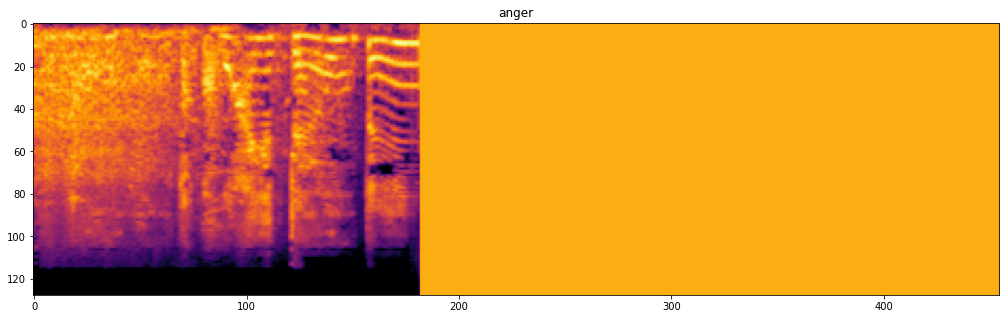

In [ ]:
plt.figure(1,figsize=(18,5))
plt.imshow(img,cmap='inferno');
plt.title(lbl)

In [ ]:
IPython.display.Audio(loc)

In [ ]:
from tqdm.notebook import tqdm
import zipfile
import io
from joblib import Parallel,delayed

### Saving for faster model training and validation.

In [ ]:
OUT_TRAIN = 'TrainEmo.zip'

In [ ]:
files = df['file_path'].values

In [ ]:
x_tot,x2_tot = [],[]
batch = 8
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out:
    for idx in tqdm(range(0,len(files),batch)):
        names = files[idx:idx+batch]
        out = Parallel(n_jobs=-1)(delayed(build_spectrogram)(i) for i in names)
        for s in range(len(out)):
            img = out[s]
            x_tot.append((img/255.0).mean())
            x2_tot.append(((img/255.0)**2).mean()) 
            name = names[s].split('/')[-1].split('.')[0]
            img = cv2.imencode('.png',img)[1]
            img_out.writestr(name + '.png', img)

  0%|          | 0/727 [00:00<?, ?it/s]

In [ ]:
tsdf = pd.read_csv('/content/dataset/test.csv')

In [ ]:
tsdf['file_path'] = tsdf['filename'].apply(lambda x:f'/content/dataset/TestAudioFiles/{x}')

In [ ]:
tsdf.head(3)

,filename,file_path
0,26199.mp3,/content/dataset/TestAudioFiles/26199.mp3
1,692.mp3,/content/dataset/TestAudioFiles/692.mp3
2,16821.mp3,/content/dataset/TestAudioFiles/16821.mp3


In [ ]:
tsfiles = tsdf['file_path'].values
OUT_TRAIN = 'TestEmo.zip'

In [ ]:
x_tot,x2_tot = [],[]
batch = 8
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out:
    for idx in tqdm(range(0,len(tsfiles),batch)):
        names = tsfiles[idx:idx+batch]
        out = Parallel(n_jobs=-1)(delayed(build_spectrogram)(i) for i in names)
        for s in range(len(out)):
            img = out[s]
            x_tot.append((img/255.0).mean())
            x2_tot.append(((img/255.0)**2).mean()) 
            name = names[s].split('/')[-1].split('.')[0]
            img = cv2.imencode('.png',img)[1]
            img_out.writestr(name + '.png', img)

  0%|          | 0/312 [00:00<?, ?it/s]

In [ ]:
# !cp '/content/TrainEmoa.zip' '/content/drive/MyDrive/Dataset'

In [ ]:
# !cp '/content/TestEmo.zip' '/content/drive/MyDrive/Dataset'

In [ ]:
def get_len(x):
    y,sr = librosa.load(x,sr=44100)
    return y.shape[0]/sr

In [ ]:
durations = Parallel(n_jobs=-1, verbose=10)(delayed(get_len)(l) for l in df['file_path'].values)

In [ ]:
df['duration'] = durations

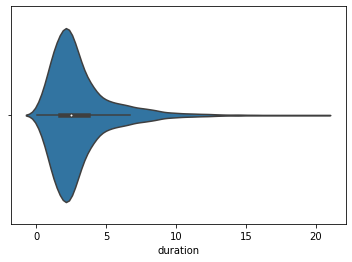

In [ ]:
sns.violinplot(df.duration);

In [ ]:
# df.to_csv('train_hack.csv',index=False)